# Minimum, Maximum, and Mixture

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we computed distributions of sums.
In this chapter, we'll compute distributions of minimums and maximums, and use them to solve both forward and inverse problems.

Then we'll look at distributions that are mixtures of other distributions, which will turn out to be particularly useful for making predictions.

But we'll start with a powerful tool for working with distributions, the cumulative distribution function.

## Cumulative Distribution Functions

So far we have been using probability mass functions to represent distributions.
A useful alternative is the **cumulative distribution function**, or CDF.

As an example, I'll use the posterior distribution from the Euro problem, which we computed in <<_BayesianEstimation>>.

Here's the uniform prior we started with.

In [4]:
# Euro problem, belgian euro coin falls too many times heads 140 times out of 250

# hypothesis: true probability of coin falling heads
import numpy as np
from empiricaldist import Pmf
from scipy.stats import binom

hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)
data  = 140, 250

# update pmf with binomial likelihood
def update_binomial(pmf, data):
    # k heads out of n tosses
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf = pmf * likelihood 
    pmf.normalize()
    return pmf


In [5]:
prior.normalize()
prior

,probs
0.00,0.009901
0.01,0.009901
0.02,0.009901
0.03,0.009901
0.04,0.009901
...,...
0.96,0.009901
0.97,0.009901
0.98,0.009901
0.99,0.009901


<Axes: >

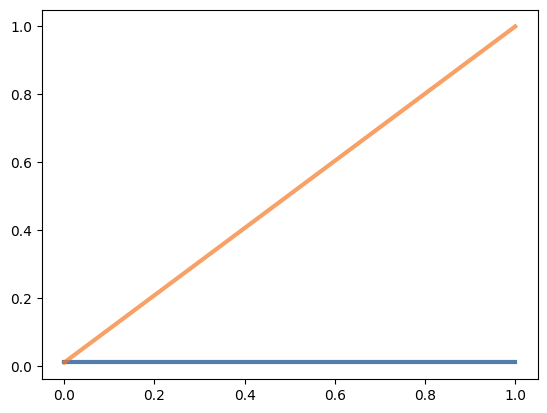

In [6]:
prior.plot(label = "prior")
prior.make_cdf().plot(label = "prior cdf")

<Axes: >

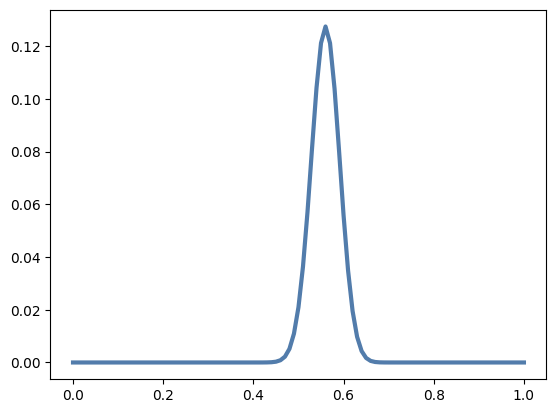

In [7]:
pmf = update_binomial(prior.copy(), data)
pmf.plot()

The CDF is the cumulative sum of the PMF, so we can compute it like this:

In [8]:
cumulative = pmf.cumsum()

Here's what it looks like, along with the PMF.

In [9]:
from utils import decorate
import matplotlib.pyplot as plt

def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

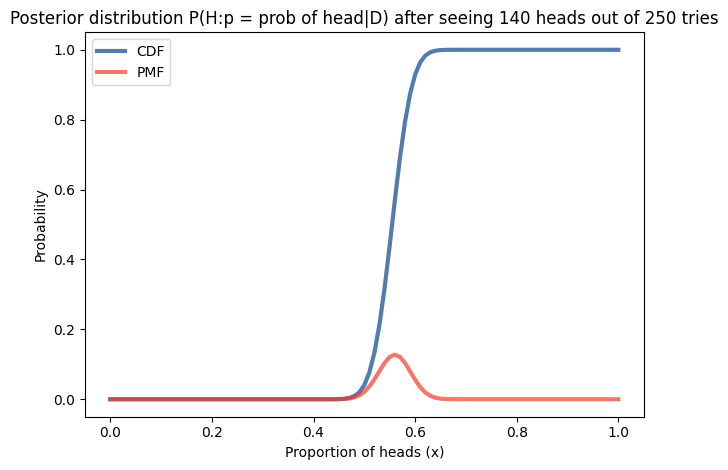

In [10]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF', color = 'C3')
# plt.axvline(pmf.max_prob(), color = 'C3')
decorate_euro(title='Posterior distribution P(H:p = prob of head|D) after seeing 140 heads out of 250 tries')

In [11]:

pmf.max_prob()


0.56

The range of the CDF is always from 0 to 1, in contrast with the PMF, where the maximum can be any probability.

The result from `cumsum` is a Pandas `Series`, so we can use the bracket operator to select an element:

In [12]:
# P(p <= 0.61)
# probability of all quantities less than or equal to 0.61
# probability of all hypotheses that say coin is less than or equal to 0.61 probable to fall heads.

cumulative[0.61]

0.9638303193984255

In [13]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.964) #TODO Q: Interpolation = forward fill ? 

# interp(cumulative[0.61]) 

array(0.61008697)

The result is about 0.96, which means that the total probability of all quantities less than or equal to 0.61 is 96%.

To go the other way --- to look up a probability and get the corresponding quantile --- we can use interpolation:

In [14]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

In [15]:
cdf = pmf.make_cdf()
cdf(0.615) #NOTE: missing quantities are interpolated 

array(0.96383032)

The result is about 0.61, so that confirms that the 96th percentile of this distribution is 0.61.

`empiricaldist` provides a class called `Cdf` that represents a cumulative distribution function.
Given a `Pmf`, you can compute a `Cdf` like this:

In [16]:
cdf = pmf.make_cdf()

`make_cdf` uses `np.cumsum` to compute the cumulative sum of the probabilities.

You can use brackets to select an element from a `Cdf`:

In [17]:
cdf[0.61]

0.9638303193984255

But if you look up a quantity that's not in the distribution, you get a `KeyError`.


In [18]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


To avoid this problem, you can call a `Cdf` as a function, using parentheses.
If the argument does not appear in the `Cdf`, it interpolates between quantities.

In [19]:
cdf(0.615)

array(0.96383032)

Going the other way, you can use `quantile` to look up a cumulative probability and get the corresponding quantity:


In [20]:
cdf.quantile(0.963)

cdf.quantile(0.05)

cdf.quantile(0.95)

array(0.61)

`Cdf` also provides `credible_interval`, which computes a credible interval that contains the given probability:


In [21]:
# The probability of coin is between these two values with 90% probability

cdf.credible_interval(0.9)

array([0.51, 0.61])

CDFs and PMFs are equivalent in the sense that they contain the
same information about the distribution, and you can always convert
from one to the other.
Given a `Cdf`, you can get the equivalent `Pmf` like this:

In [22]:
pmf = cdf.make_pmf()

np.diff(cdf)

array([1.25633046e-207, 5.73192108e-166, 8.33871083e-142, 8.26926488e-125,
       9.65227468e-112, 3.66835564e-101, 2.66736487e-092, 1.06780431e-084,
       4.65304187e-078, 3.51486397e-072, 6.41370730e-067, 3.61161016e-062,
       7.55822114e-058, 6.79183482e-054, 2.93826241e-050, 6.71044810e-047,
       8.72311580e-044, 6.86921263e-041, 3.45214233e-038, 1.15699224e-035,
       2.68481143e-033, 4.45465520e-031, 5.43387063e-029, 4.99230918e-027,
       3.52835822e-025, 1.95429612e-023, 8.62331159e-022, 3.07561152e-020,
       8.98194825e-019, 2.17266389e-017, 4.39814559e-016, 7.51986157e-015,
       1.09499557e-013, 1.36808720e-012, 1.47648121e-011, 1.38477664e-010,
       1.13483911e-009, 8.16623464e-009, 5.18273876e-008, 2.91251930e-007,
       1.45443295e-006, 6.47459237e-006, 2.57662009e-005, 9.18946361e-005,
       2.94360991e-004, 8.48481738e-004, 2.20433832e-003, 5.16860705e-003,
       1.09497211e-002, 2.09765261e-002, 3.63601729e-002, 5.70475114e-002,
       8.10249180e-002, 1

`make_pmf` uses `np.diff` to compute differences between consecutive cumulative probabilities.

One reason `Cdf` objects are useful is that they compute quantiles efficiently.
Another is that they make it easy to compute the distribution of a maximum or minimum, as we'll see in the next section.

## Best Three of Four

In *Dungeons & Dragons*, each character has six attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma.

To generate a new character, players roll four 6-sided dice for each attribute and add up the best three.
For example, if I roll for strength and get 1, 2, 3, 4 on the dice, my character's strength would be the sum of 2, 3, and 4, which is 9.

As an exercise, let's figure out the distribution of these attributes.
Then, for each character, we'll figure out the distribution of their best attribute.

I'll import two functions from the previous chapter: `make_die`, which makes a `Pmf` that represents the outcome of rolling a die, and `add_dist_seq`, which takes a sequence of `Pmf` objects and computes the distribution of their sum.

Here's a `Pmf` that represents a six-sided die and a sequence with three references to it.

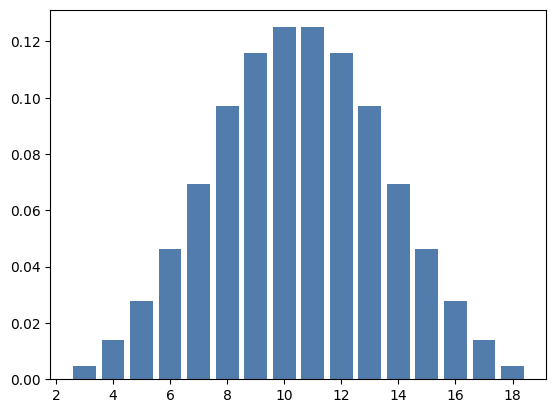

In [23]:
# NOTE: 6 attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma
# Roll 4 dice for each, sum( max 3) -> points for specific attribute

# Maximum:
# pmf_max3 -> mapping: sum_max_3 value -> probability  
# cdf_max3 -> probability sum_max_3 value is less than < x
# 6 attributes each <= x : cdf_max3 * cdf_max3 .... 
# 6 attributes each cdf_max3**6 

# Minimum:
# pmf_min3 -> mapping: sum_min_3 value -> probability  
# cdf_min3 -> mapping: sum_min_3 <= x -> probability
# (1- cdf_min3) -> mapping: sum_min3 > x  -> probability 
# 6 attributes each (1 - cdf_min3)**6


from utils import make_die, add_dist_seq

from empiricaldist import Cdf

die = make_die(6)
dice = [die] * 3

pmf_3d6 = add_dist_seq(dice)
pmf_3d6.bar()

In [24]:
from utils import make_die

die = make_die(6)
dice = [die] * 3


And here's the distribution of the sum of three dice.

In [25]:
from utils import add_dist_seq

pmf_3d6 = add_dist_seq(dice)

Here's what it looks like:

In [26]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

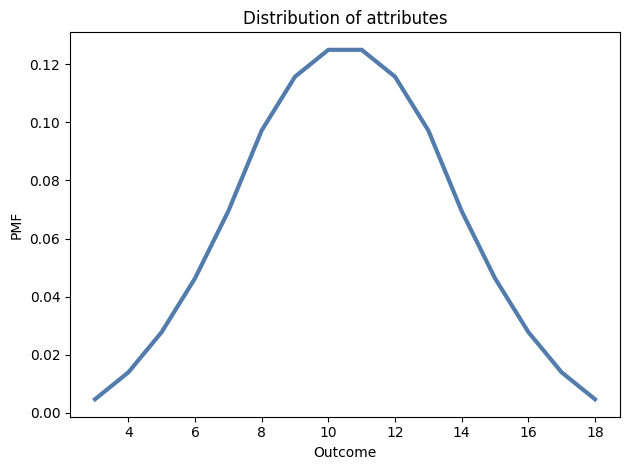

In [27]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

If we roll four dice and add up the best three, computing the distribution of the sum is a bit more complicated.
I'll estimate the distribution by simulating 10,000 rolls.

First I'll create an array of random values from 1 to 6, with 10,000 rows and 4 columns:

In [28]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))
a

array([[4, 3, 6, 2],
       [4, 2, 4, 4],
       [4, 5, 5, 1],
       ...,
       [4, 2, 2, 3],
       [5, 2, 5, 5],
       [3, 2, 3, 3]])

To find the best three outcomes in each row, I'll use `sort` with `axis=1`, which sorts the rows in ascending order.

In [29]:
a.sort(axis=1)
a

array([[2, 3, 4, 6],
       [2, 4, 4, 4],
       [1, 4, 5, 5],
       ...,
       [2, 2, 3, 4],
       [2, 5, 5, 5],
       [2, 3, 3, 3]])

In [30]:
# select best three outcomes each
a[:, 1:]

# worst three outcomes each 

# a[:,:-1]

array([[3, 4, 6],
       [4, 4, 4],
       [4, 5, 5],
       ...,
       [2, 3, 4],
       [5, 5, 5],
       [3, 3, 3]])

Finally, I'll select the last three columns and add them up.

In [31]:
t = a[:, 1:].sum(axis=1)
t

array([13, 12, 14, ...,  9, 15,  9])

In [32]:
# t_worst = a[:,:-1].sum(axis=1)
# t_worst

Now `t` is an array with a single column and 10,000 rows.
We can compute the PMF of the values in `t` like this:

In [33]:
pmf_best3 = Pmf.from_seq(t)
# pmf_worst3 = Pmf.from_seq(t_worst)

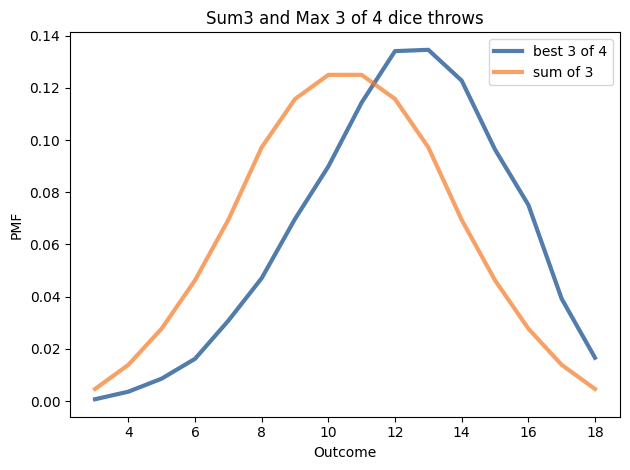

In [34]:
pmf_best3.plot(label="best 3 of 4")
pmf_3d6.plot(label='sum of 3')
# pmf_worst3.plot(label ="worst 3 of 4")

decorate_dice("Sum3 and Max 3 of 4 dice throws")

The following figure shows the distribution of the sum of three dice, `pmf_3d6`, and the distribution of the best three out of four, `pmf_best3`.

As you might expect, choosing the best three out of four tends to yield higher values.

Next we'll find the distribution for the maximum of six attributes, each the sum of the best three of four dice.

## Maximum

To compute the distribution of a maximum or minimum, we can make good use of the cumulative distribution function.
First, I'll compute the `Cdf` of the best three of four distribution:

In [35]:
# cdf_best3: mapping: sum_best_3 <= x
# prob_gt: 1 - cdf_best3 mapping: sum_best3 > x

cdf_best3 = pmf_best3.make_cdf()
prob_gt = Cdf(1 - cdf_best3) # complementary CDF

<Axes: >

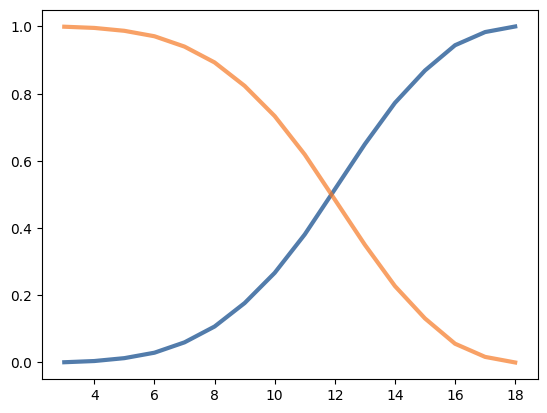

In [36]:
cdf_best3.plot()
prob_gt.plot()

Recall that `Cdf(x)` is the sum of probabilities for quantities less than or equal to `x`.
Equivalently, it is the probability that a random value chosen from the distribution is less than or equal to `x`.

Now suppose I draw 6 values from this distribution.
The probability that all 6 of them are less than or equal to `x` is `Cdf(x)` raised to the 6th power, which we can compute like this:

In [37]:
cdf_best3**6

3     1.176490e-19
4     6.321363e-15
5     4.608274e-12
6     6.072366e-10
7     4.619138e-08
8     1.500730e-06
9     3.054173e-05
10    3.598637e-04
11    3.063612e-03
12    1.870058e-02
13    7.527976e-02
14    2.126808e-01
15    4.306443e-01
16    7.085720e-01
17    9.044430e-01
18    1.000000e+00
Name: , dtype: float64

If all 6 values are less than or equal to `x`, that means that their maximum is less than or equal to `x`.
So the result is the CDF of their maximum.
We can convert it to a `Cdf` object, like this:

In [38]:
# NOTE: Maximum, Minimum

# cdf_max6: prob 6 x sum_max3 <= x, ALL 6 attributes less or equal x
# prob_gt6: prob 6 x sum_max3 > x, ALL 6 attributes more than x


from empiricaldist import Cdf

# I draw 6 times from the distribution, all 6 are less than or equal x => their maximum is less than or equal to x
cdf_max6 = Cdf(cdf_best3**6)

# We draw 6 times from distribution, probability that all 6 exceed x => their minimum exceeds x 
prob_gt6 = Cdf((prob_gt)**6)

# NOTE:
# If all 6 exceed `x`, that means their minimum exceeds `x`, so `prob_gt6` is the complementary CDF to CDF that at least one does not exceed X
# And that means we can compute the CDF of the minimum like this:
# 1 - probability that all 6 exceed x  ~ probability that some of the 6 is less than x ~ SOME OF THEM IS LESS THAN X ~ MINIMUM OF 6 IS LESS THAN X
prob_le6 = 1 - prob_gt6
cdf_min6 = Cdf(prob_le6)


And compute the equivalent `Pmf` like this:

In [39]:
pmf_max6 = cdf_max6.make_pmf()
pmf_min6 = cdf_min6.make_pmf()

pmf_min6

,probs
3,4.192657e-03
4,2.133158e-02
5,4.942214e-02
6,8.743369e-02
7,1.473097e-01
8,1.831926e-01
9,1.959230e-01
10,1.557091e-01
11,9.928731e-02
12,4.321525e-02


The following figure shows the result.

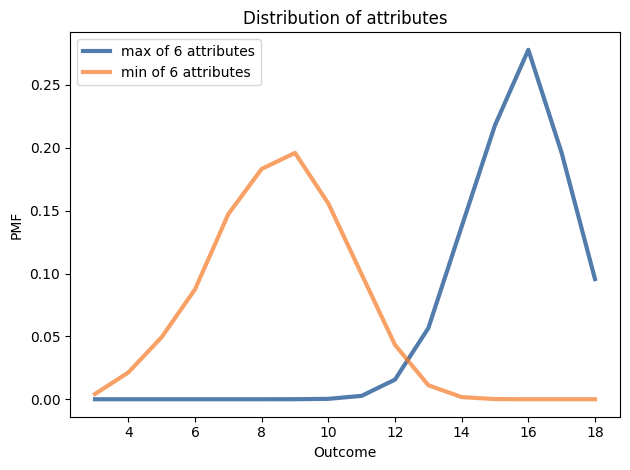

In [40]:
pmf_max6.plot(label='max of 6 attributes')
pmf_min6.plot(label='min of 6 attributes')

decorate_dice('Distribution of attributes')

Most characters have at least one attribute greater than 12; almost 10% of them have an 18.

Most characters have all attributes greater than 4


The following figure shows the CDFs for the three distributions we have computed.

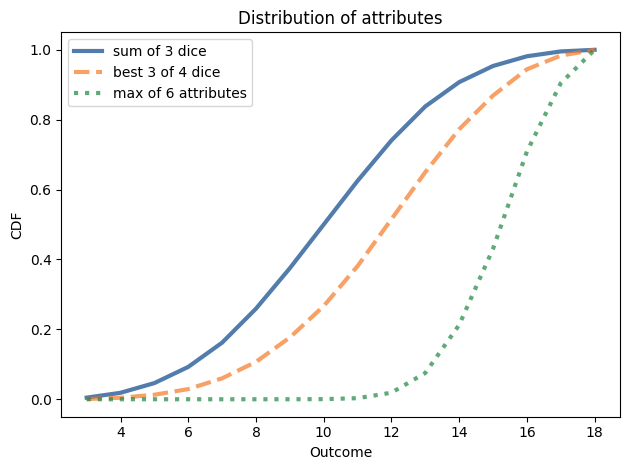

In [41]:
import matplotlib.pyplot as plt

cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='sum of 3 dice')

cdf_best3 = pmf_best3.make_cdf()
cdf_best3.plot(label='best 3 of 4 dice', ls='--')

cdf_max6.plot(label='max of 6 attributes', ls=':')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

`Cdf` provides `max_dist`, which does the same computation, so we can also compute the `Cdf` of the maximum like this:

In [42]:
cdf_max_dist6 = cdf_best3.max_dist(6)

And we can confirm that the differences are small.

In [43]:
np.allclose(cdf_max_dist6, cdf_max6)

True

In [44]:
# TODO minimum
cdf_min_dist6 = cdf_best3.min_dist(6)
np.allclose(cdf_min_dist6, cdf_min6)

True

In the next section we'll find the distribution of the minimum.
The process is similar, but a little more complicated.
See if you can figure it out before you go on.

## Minimum

In the previous section we computed the distribution of a character's best attribute.
Now let's compute the distribution of the worst.

To compute the distribution of the minimum, we'll use the **complementary CDF**, which we can compute like this:

In [45]:
prob_gt = 1 - cdf_best3

As the variable name suggests, the complementary CDF is the probability that a value from the distribution is greater than `x`.
If we draw 6 values from the distribution, the probability that all 6 exceed `x` is:

In [46]:
prob_gt6 = prob_gt**6

If all 6 exceed `x`, that means their minimum exceeds `x`, so `prob_gt6` is the complementary CDF of the minimum.
And that means we can compute the CDF of the minimum like this:

In [47]:
prob_le6 = 1 - prob_gt6

The result is a Pandas `Series` that represents the CDF of the minimum of six attributes.  We can put those values in a `Cdf` object like this:

In [48]:
cdf_min6 = Cdf(prob_le6)

Here's what it looks like, along with the distribution of the maximum.

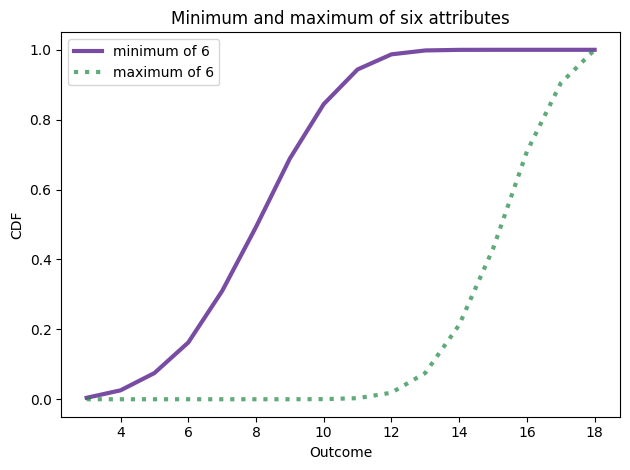

In [49]:
cdf_min6.plot(color='C4', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6', ls=':')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF');

`Cdf` provides `min_dist`, which does the same computation, so we can also compute the `Cdf` of the minimum like this:

In [50]:
cdf_min_dist6 = cdf_best3.min_dist(6)

And we can confirm that the differences are small.

In [51]:
np.allclose(cdf_min_dist6, cdf_min6)

True

In the exercises at the end of this chapter, you'll use distributions of the minimum and maximum to do Bayesian inference.
But first we'll see what happens when we mix distributions.

## Mixture

In this section I'll show how we can compute a distribution which is a mixture of other distributions.
I'll explain what that means with some simple examples;
then, more usefully, we'll see how these mixtures are used to make predictions.

Here's another example inspired by *Dungeons & Dragons*:

* Suppose your character is armed with a dagger in one hand and a short sword in the other.

* During each round, you attack a monster with one of your two weapons, chosen at random.

* The dagger causes one 4-sided die of damage; the short sword causes one 6-sided die of damage.

What is the distribution of damage you inflict in each round?

To answer this question, I'll make a `Pmf` to represent the 4-sided and 6-sided dice:

In [52]:
d4 = make_die(4)
d6 = make_die(6)

d4

,probs
1,0.25
2,0.25
3,0.25
4,0.25


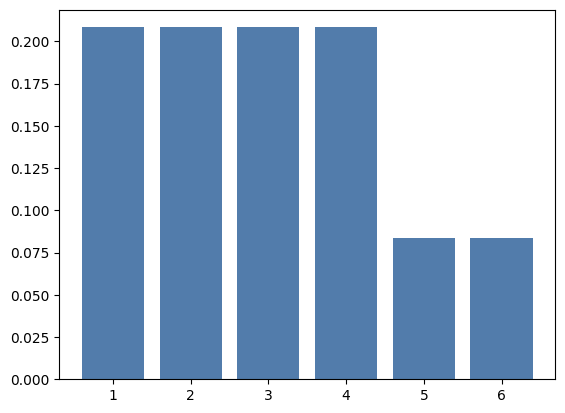

In [53]:
d4 = make_die(4)
d6 = make_die(6)

mix1 = (d4 + d6) / 2
mix1.bar()

Now, let's compute the probability you inflict 1 point of damage.

* If you attacked with the dagger, it's 1/4.

* If you attacked with the short sword, it's 1/6.

Because the probability of choosing either weapon is 1/2, the total probability is the average:

In [54]:
# uniform probability of choosing either weapon 1/2, 1/2, hence

(d4(1) + d6(1))/2


0.20833333333333331

In [55]:
# prob of damage 6
(d4(6) + d6(6))/2

0.08333333333333333

In [56]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

For the outcomes 2, 3, and 4, the probability is the same, but for 5 and 6 it's different, because those outcomes are impossible with the 4-sided die.

In [57]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

To compute the distribution of the mixture, we could loop through the possible outcomes and compute their probabilities.

But we can do the same computation using the `+` operator:

In [58]:
mix1 = (d4 + d6) / 2

Here's what the mixture of these distributions looks like.

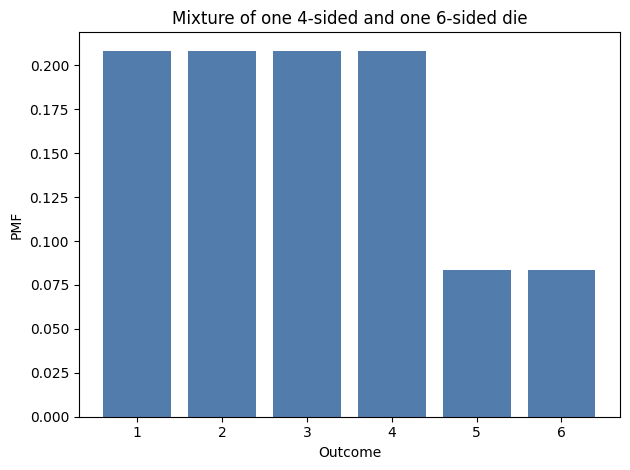

In [59]:
mix1.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and one 6-sided die')

Now suppose you are fighting three monsters:

* One has a club, which causes one 4-sided die of damage.

* One has a mace, which causes one 6-sided die.

* And one has a quarterstaff, which also causes one 6-sided die. 

Because the melee is disorganized, you are attacked by one of these monsters each round, chosen at random.
To find the distribution of the damage they inflict, we can compute a weighted average of the distributions, like this:

In [60]:
# NOTE: adding probabilitis in distribution because of OR relationship
# NOTE: do not confused with computing distribution of the sum of distributions.

mix2 = (d4 + d6 + d6)/3
# mix2.sum()
# mix2.bar()

This distribution is a mixture of one 4-sided die and two 6-sided dice.
Here's what it looks like.

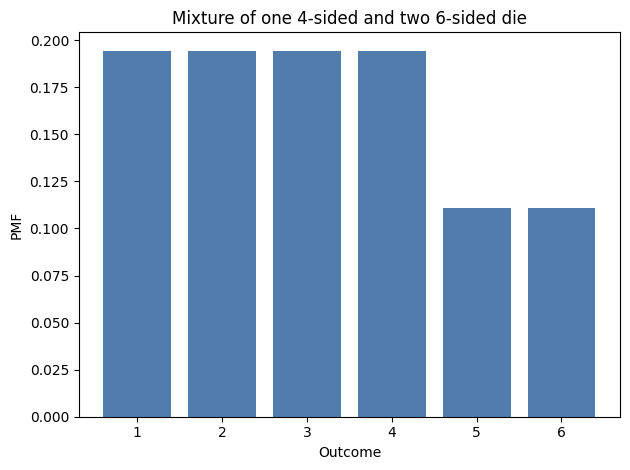

In [61]:
mix2.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and two 6-sided die')

In this section we used the `+` operator, which adds the probabilities in the distributions, not to be confused with `Pmf.add_dist`, which computes the distribution of the sum of the distributions.

To demonstrate the difference, I'll use `Pmf.add_dist` to compute the distribution of the total damage done per round, which is the sum of the two mixtures:

In [62]:
total_damage = Pmf.add_dist(mix1, mix2)

And here's what it looks like.

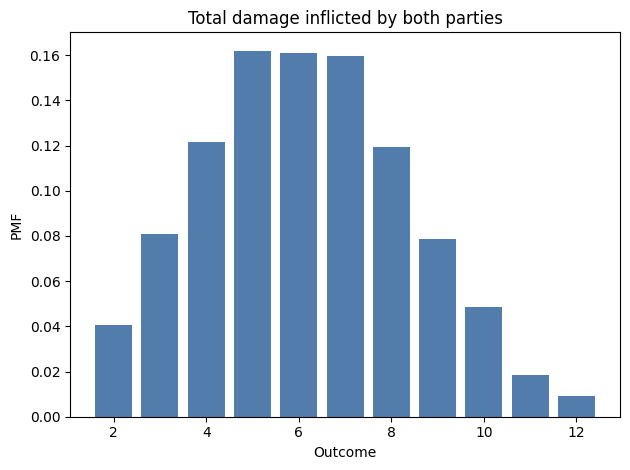

In [63]:
# NOTE: damage caused by two parties of monsters: partyA: dagger + shortsword AND partyB: club + mace + quarterstaff

total_damage.bar(alpha=0.7)
decorate_dice('Total damage inflicted by both parties')

## General Mixtures

In the previous section we computed mixtures in an *ad hoc* way.
Now we'll see a more general solution.
In future chapters, we'll use this solution to generate predictions for real-world problems, not just role-playing games.
But if you'll bear with me, we'll continue the previous example for one more section.

Suppose three more monsters join the combat, each of them with a battle axe that causes one 8-sided die of damage.
Still, only one monster attacks per round, chosen at random, so the damage they inflict is a mixture of:

* One 4-sided die,
* Two 6-sided dice, and
* Three 8-sided dice.

I'll use a `Pmf` to represent a randomly chosen monster:

In [64]:
# NOTE: two parties of monsters: partyA: club 4 + mace 6 + quarterstaff 6 + PARTY C: 3 x battle axe 8
# NOTE: one monster attacks per round.

hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

1/6, 2/6, 3/6

pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


This distribution represents the number of sides on the die we'll roll and the probability of rolling each one.
For example, one of the six monsters has a dagger, so the probability is $1/6$ that we roll a 4-sided die.

Next I'll make a sequence of `Pmf` objects to represent the dice:

In [65]:
dice = [make_die(sides) for sides in hypos]
dice

[1    0.25
 2    0.25
 3    0.25
 4    0.25
 Name: , dtype: float64,
 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64,
 1    0.125
 2    0.125
 3    0.125
 4    0.125
 5    0.125
 6    0.125
 7    0.125
 8    0.125
 Name: , dtype: float64]

To compute the distribution of the mixture, I'll compute the weighted average of the dice, using the probabilities in `pmf_dice` as the weights.

To express this computation concisely, it is convenient to put the distributions into a Pandas `DataFrame`:

In [66]:
import pandas as pd

df = pd.DataFrame(dice)
df


,1,2,3,4,5,6,7,8
,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


The result is a `DataFrame` with one row for each distribution and one column for each possible outcome.
Not all rows are the same length, so Pandas fills the extra spaces with the special value `NaN`, which stands for "not a number".
We can use `fillna` to replace the `NaN` values with 0.

In [67]:
df = pd.DataFrame(dice)

df = df.fillna(0)

print("rows are values of damage, columns represent the three dice, 4, 6, 8 sided")
df.T

rows are values of damage, columns represent the three dice, 4, 6, 8 sided


,,,
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


In [68]:
# NOTE: each time choosing die randomly our of 1: 4 sided, 2: 6 sided, 3: 8 sided
# pmf_dice represents the respective count of dice in the form of probability

# weighted avg, weighted by pmf_dice.ps represent the distributions
np.sum(df.T * pmf_dice.ps, axis = 1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

The next step is to multiply each row by the probabilities in `pmf_dice`, which turns out to be easier if we transpose the matrix so the distributions run down the columns rather than across the rows:

In [69]:
df = pd.DataFrame(dice).fillna(0).transpose()
df

,,,
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


Now we can multiply by the probabilities in `pmf_dice`:


In [70]:
df = pd.DataFrame(dice).fillna(0).transpose()
df *= pmf_dice.ps
df

,,,
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


And add up the weighted distributions:

In [71]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

In [72]:
def make_mixture(pmf_weights: Pmf, pmf_seq: list):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df = df * np.array(pmf_weights) # "Weight" the probs of outcomes by probabilities in pmf_weights
    prob_weighted_avg = Pmf(df.sum(axis=1))
    return prob_weighted_avg

make_mixture(pmf_dice, dice)

# np.array(pmf_dice)

,probs
1,0.159722
2,0.159722
3,0.159722
4,0.159722
5,0.118056
6,0.118056
7,0.062500
8,0.062500


The argument `axis=1` means we want to sum across the rows.
The result is a Pandas `Series`.

Putting it all together, here's a function that makes a weighted mixture of distributions.

The first parameter is a `Pmf` that maps from each hypothesis to a probability.
The second parameter is a sequence of `Pmf` objects, one for each hypothesis.
We can call it like this:

In [73]:
mix = make_mixture(pmf_dice, dice)

And here's what it looks like.

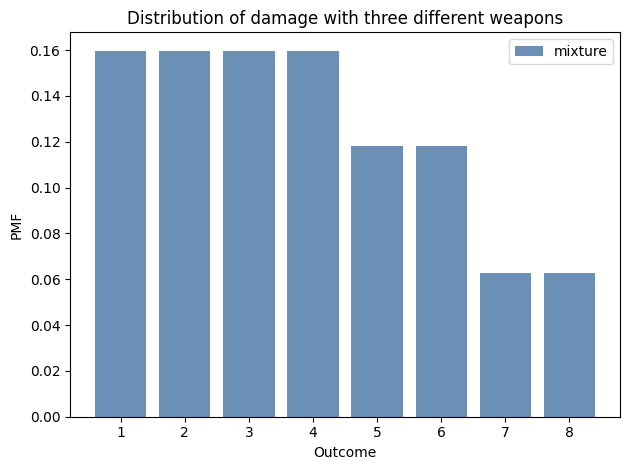

In [74]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Distribution of damage with three different weapons')

In this section I used Pandas so that `make_mixture` is concise, efficient, and hopefully not too hard to understand.
In the exercises at the end of the chapter, you'll have a chance to practice with mixtures, and we will use `make_mixture` again in the next chapter.

## Summary

This chapter introduces the `Cdf` object, which represents the cumulative distribution function (CDF).

A `Pmf` and the corresponding `Cdf` are equivalent in the sense that they contain the same information, so you can convert from one to the other.  
The primary difference between them is performance: some operations are faster and easier with a `Pmf`; others are faster with a `Cdf`.

In this chapter we used `Cdf` objects to compute distributions of maximums and minimums; these distributions are useful for inference if we are given a maximum or minimum as data.
You will see some examples in the exercises, and in future chapters.
We also computed mixtures of distributions, which we will use in the next chapter to make predictions.

But first you might want to work on these exercises.

## Exercises

**Exercise:** When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.
Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

To get you started, here's a `Cdf` that represents the distribution of attributes in the standard array:

In [75]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)
pmf_standard = cdf_standard.make_pmf()

In [76]:
# best 3 of 4 
np.random.seed(1)
n = 10000
a = np.random.randint(1, 7, size=(n, 4))

# find best three attributes, sort in increasing order 
a.sort(axis=1)

best3of4 = a[:, 1:]
best3of4
t = best3of4.sum(axis=1)
t

pmf_best3 = Pmf.from_seq(t)
cdf_best3 = pmf_best3.make_cdf()
pmf_best3

,probs
3,0.0009
4,0.0024
5,0.0065
6,0.0161
7,0.0282
8,0.0491
9,0.0749
10,0.0924
11,0.1167
12,0.1295


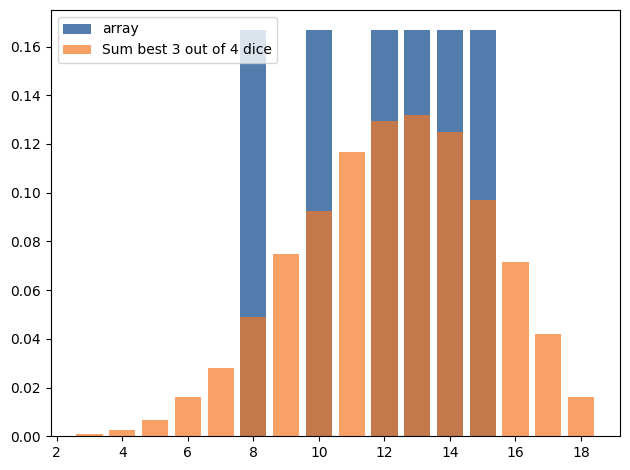

In [77]:
pmf_standard.bar(label = "array")
pmf_best3.bar(label = "Sum best 3 out of 4 dice")
decorate()

We can compare it to the distribution of attributes you get by rolling four dice at adding up the best three.

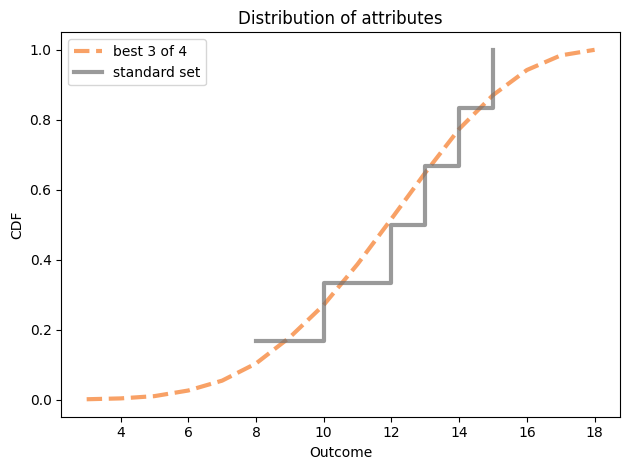

In [78]:
cdf_best3.plot(label='best 3 of 4', color='C1', ls='--')
# cdf_best3.step(label='best 3 of 4', color='C1', ls='--')
# cdf_standard.plot(label = "standard set")
cdf_standard.step(label='standard set', color='C7')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

I plotted `cdf_standard` as a step function to show more clearly that it contains only a few quantities.

In [79]:
# Solution goes here
cdf_standard.mean(), cdf_standard.std()


(12.0, 2.3804761428476167)

In [80]:
# Solution goes here
cdf_best3.mean(), cdf_best3.std()

(12.231299999999997, 2.8273663204473523)

In [81]:
# Solution goes here


In [82]:
# Solution goes here
cdf_standard(8) # prob(x <= 8)


array(0.16666667)

In [83]:
# Solution goes here
# * The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?
cdf_best3(7)

np.allclose(
    cdf_best3(7),
    cdf_best3.lt_dist(8)
)


prob_gt8 = 1 - cdf_best3.lt_dist(8) # one attribute greater or equal than 8

# 1 - prob(all 6 attributes are greater than or equal 8) ~ prob any one of the attributes is less than 8
1 - prob_gt8**6

1 - (1 - cdf_best3(7))**6

# np.allclose()

0.2837389206906352

In [84]:
np.allclose(
    1 - prob_gt8**6,
    1 - (1 - cdf_best3(7))**6
)

True

In [85]:
# Solution goes here
# * The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

# 1 - prob(x <= 15) ~ prob(x > 15)
prob_gt15 = 1 - cdf_best3(15) 

np.allclose(
    cdf_best3.gt_dist(15),
    prob_gt15
)



prob_all6_le15 = cdf_best3(15)**6 # all 6 less than or equal 15


# 1st roll OR 2nd roll OR 3rd roll 
# NOTE: check why this is not equal
# NOTE: double counting P(A U B) = P(A) + P(B) - P(A ∩ B).
# NOTE: triple counting P(A U B U C) = P(A) + P(B) + P(C) - P(A ∩ B) - P(A ∩ C) - P(B ∩ C) + P(A ∩ B ∩ C)
prob_gt15 * 6
# TODO: try this formula on the above

# 1 - prob(all 6 less than or equal 15) = prob(any of the 6 is greater than 15)
1 - prob_all6_le15

0.5648763862158954

**Exercise:** Suppose you are fighting three monsters:

* One is armed with a short sword that causes one 6-sided die of damage,

* One is armed with a battle axe that causes one 8-sided die of damage, and

* One is armed with a bastard sword that causes one 10-sided die of damage.

One of the monsters, chosen at random, attacks you and does 1 point of damage.

Which monster do you think it was?  Compute the posterior probability that each monster was the attacker.

If the same monster attacks you again, what is the probability that you suffer 6 points of damage?

Hint: Compute a posterior distribution as we have done before and pass it as one of the arguments to `make_mixture`.

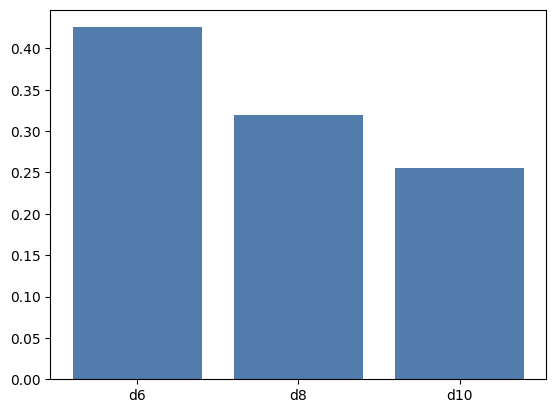

In [100]:
#NOTE: CTRL SHIFT MINUS, splits the current cell at cursor

# Solution goes here
d6 = make_die(6)
d8 = make_die(8)
d10 = make_die(10)

prior = Pmf([1/3, 1/3, 1/3], ['d6', 'd8', 'd10'])
prior

# D = (damage = 1)
# Likelihood P(D|H)

likelihood = 1/6, 1/8, 1/10 

# P(H|D)

posterior = prior * likelihood
posterior.normalize()
posterior.bar()


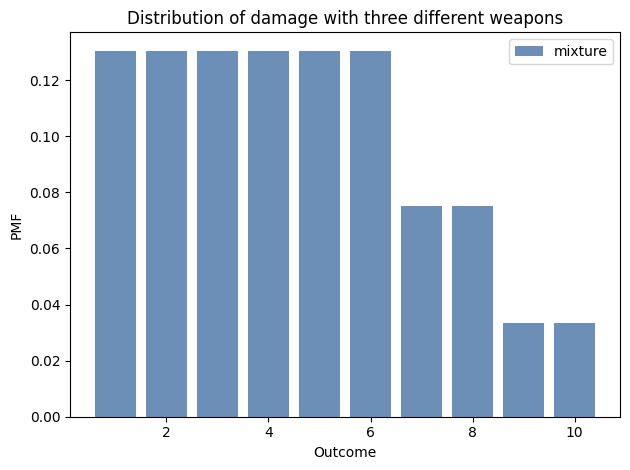

In [106]:

damage_prior = make_mixture(prior, [d6, d8, d10])
damage_prior

damage_prior.bar(label='mixture', alpha=0.6)
decorate_dice('Distribution of damage with three different weapons')

# P(Damage)


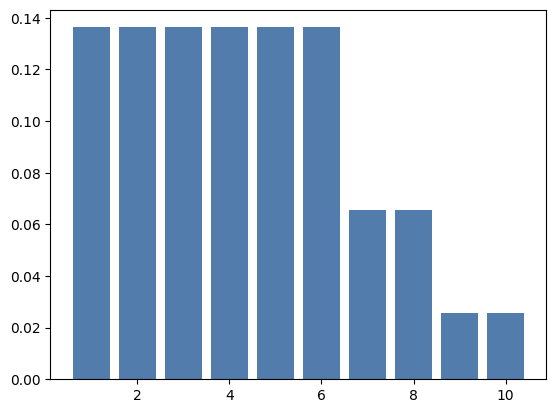

In [107]:
# P(D|M) = P(D) * P(M|D=1)  
posterior_weighted_damage = make_mixture(posterior, [d6, d8, d10])
posterior_weighted_damage.bar()

In [133]:

monsters = [d6, d8, d10]
df = pd.DataFrame(monsters).fillna(0).transpose()

# NOTE: prob of each damage value(rows) w.r.t to the monster(columns) 
df


,,,
1,0.166667,0.125,0.1
2,0.166667,0.125,0.1
3,0.166667,0.125,0.1
4,0.166667,0.125,0.1
5,0.166667,0.125,0.1
6,0.166667,0.125,0.1
7,0.000000,0.125,0.1
8,0.000000,0.125,0.1
9,0.000000,0.000,0.1
10,0.000000,0.000,0.1


In [136]:
#NOTE: Prob Damage X Monster * equal prob. d6 monster or d8 monster or d10 monster with equal prob
df * prior.ps


,,,
1,0.055556,0.041667,0.033333
2,0.055556,0.041667,0.033333
3,0.055556,0.041667,0.033333
4,0.055556,0.041667,0.033333
5,0.055556,0.041667,0.033333
6,0.055556,0.041667,0.033333
7,0.000000,0.041667,0.033333
8,0.000000,0.041667,0.033333
9,0.000000,0.000000,0.033333
10,0.000000,0.000000,0.033333


In [135]:
# NOTE: We have already seen the monster hit with damage 1, hence we weight the possibilities not by prior but by updated posterior with this information that first damage was 1
# NOTE: Damage 1 observed makes the "smaller" monsters more likely
df * posterior.ps


,,,
1,0.070922,0.039894,0.025532
2,0.070922,0.039894,0.025532
3,0.070922,0.039894,0.025532
4,0.070922,0.039894,0.025532
5,0.070922,0.039894,0.025532
6,0.070922,0.039894,0.025532
7,0.000000,0.039894,0.025532
8,0.000000,0.039894,0.025532
9,0.000000,0.000000,0.025532
10,0.000000,0.000000,0.025532


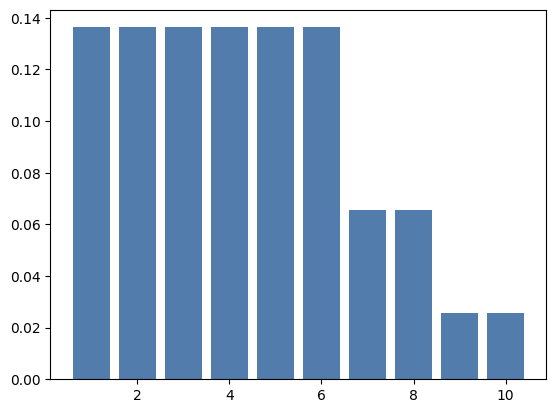

In [141]:
# NOTE: we sum each row, had it been monster d6 before or d8 before or d10 before for damage 6, hence sum(row 6)
posterior_weighted_damage = Pmf(np.sum(df * posterior.ps, axis = 1))
posterior_weighted_damage.bar()

In [143]:
posterior_weighted_damage(6)

0.13634751773049647

In [144]:
# Solution goes here
posterior_weighted_damage.mean()

4.329787234042554

In [146]:
posterior_weighted_damage.credible_interval(0.9)

array([1., 9.])

**Exercise:** Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fiction, but it makes an interesting probability problem.

Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued to weigh his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the new distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `n` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?

To get you started, I'll generate a year's worth of data from a normal distribution with the given parameters.

In [91]:
mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

In [92]:
# Solution goes here

In [93]:
# Solution goes here